In [0]:
# Dependencies
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics import classification_report


import warnings
warnings.filterwarnings("ignore")

In [0]:
# Read in data from S3 Buckets
url = "https://job-postings-dataviz.s3.amazonaws.com/fake_jobs_clean.csv"
df = pd.read_csv(url, sep=",",  encoding = "UTF-8" )

# Show DataFrame
# df.head()

In [50]:
# Focus only on the job description. Create a dataFrame with label "fraudulent" and "description"
descrip_df =df [['fraudulent','description']]
descrip_df.head(1)

,fraudulent,description
0,0,"Food52, a fast-growing, James Beard Award-winn..."


In [51]:
# Drop NaN values but dropping duplicates is qustionable
# these duplicates are real data and contribute to both classes
print(len(descrip_df))
descrip_df= descrip_df.dropna()
print(len(descrip_df))
# descrip_df = descrip_df.drop_duplicates()
# print(descrip_df.count())

17880
17879


In [68]:
# Distrubution of the classes real vs fraudulent (fake) :
# tha dataset is higthly inbalance
df_fake= descrip_df[descrip_df['fraudulent'] == 1] 
df_real = descrip_df[descrip_df['fraudulent'] == 0] 
# Count how many Real vs Fraudulent postings
n_f=len(df_fake)
n_n=len(df_real)
print(n_f)
print(n_n)

865
17014


Create a data set with a more balance distribution (5:1 ration between real:fake posts)

In [53]:
df_new= df_real.sample  ( 5*n_f  , random_state=580)
df_unders = df_new.append(df_fake)
print(len(df_new))
print(len(df_unders))

4325
5190


In [0]:
# Shuffle the dataframe 
df_underst = df_unders.sample(len(df_unders), random_state=580) 

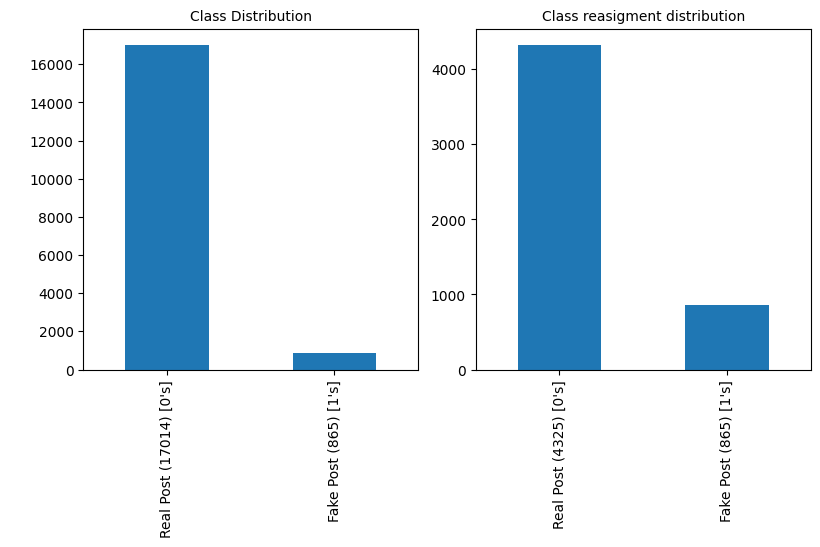

In [65]:
# Plot the original class distribution and the new distribution

fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()
descrip_df["fraudulent"].value_counts().plot.bar (ax = axes[0])
df_underst["fraudulent"].value_counts().plot.bar (ax = axes[1])

axes[0].set_ylabel(' ')
axes[0].set_xticklabels(["Real Post (17014) [0's]", "Fake Post (865) [1's]"])
axes[1].set_ylabel(' ')
axes[1].set_xticklabels(["Real Post (4325) [0's]", "Fake Post (865) [1's]"])

axes[0].set_title('Class Distribution', fontsize=10)
axes[1].set_title('Class reasigment distribution', fontsize=10)

plt.show()

In [0]:
# Assign to target ("fraudulent") and the text (description)

X_u = df_underst.iloc[:,1].values
y_u = df_underst.iloc[:,0].values

### Feature Transformations (Term Frequency times inverse document frequency)


In [8]:
# feature extraction using "bag of words" model. Create feature vectors exclude the stopword. 
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))


count_vectorizer = CountVectorizer( stop_words=stopwords.words('english'))
tfidfconverter = TfidfTransformer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#  apply the transformatins
X_c = count_vectorizer.fit_transform(X_u)
X_tfidf = tfidfconverter.fit_transform(X_c).toarray()

# y.shape

Dividing data into Training and Test sets

In [0]:
# Break the data in trainand test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_u , random_state=580)

**TRAINING THE MODEL**

**Random forest algorith**
This model can be use in non-normalized data

Loop througth th N-Estimator using the AUC (area under the curve) as evaluator![alt text](https://) 

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc


n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
   text_classifier = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   text_classifier.fit(X_train, y_train)
   train_prediction = text_classifier.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_prediction)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   test_prediction = text_classifier.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_prediction)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

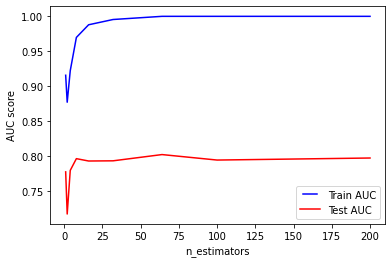

In [35]:
# plot the 
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(n_estimators, train_results, 'blue', label='Train AUC')
line2, = plt.plot(n_estimators, test_results, "red", label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

Loop througth the max_depth (depth of the threes) using the AUC (area under the curve) as evaluator


In [0]:
max_depths = np.linspace(1, 40, 20, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   text_classifier = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   text_classifier.fit(X_train, y_train)
   train_prediction = text_classifier.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_prediction)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   test_prediction = text_classifier.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_prediction)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)

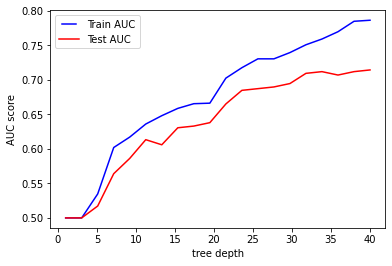

In [74]:
# plot the results to find optimal three depth
from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'blue', label='Train AUC')
line2, = plt.plot(max_depths, test_results, "red", label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('tree depth')
plt.show()

In [76]:
# Create the Random Forest model using 32 estimators 

t1_start = time()
text_classifier = RandomForestClassifier(n_estimators=32, max_depth= 35, random_state=580)
text_classifier.fit(X_train, y_train)
t1_stop = time() 
print("Elapsed time:", t1_stop, t1_start)   
print(f'Elapsed time during the whole program in seconds:',t1_stop-t1_start)

Elapsed time: 1586913855.3940885 1586913849.3695593
Elapsed time during the whole program in nanoseconds: 6.024529218673706


In [0]:
# Apply the model 
test_predictions = text_classifier.predict(X_test)

In [78]:


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, test_predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

print(f"Accuracy Score: {accuracy_score(y_test, predictions)}")
print(classification_report(y_test,predictions, target_names=["real","fake"]))


0.7142857142857143
Accuracy Score: 0.8697996918335902
              precision    recall  f1-score   support

        real       0.93      0.92      0.92      1095
        fake       0.58      0.61      0.59       203

    accuracy                           0.87      1298
   macro avg       0.75      0.76      0.76      1298
weighted avg       0.87      0.87      0.87      1298

